
I realized my AI chops are atrocious. I wrote this post for a few reasons. First, I wanted to improve my chops by working on something I've never seen before. I also wanted to get better at following tutorials online (I used [this](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial17/SimCLR.htmlv) one), since it feels like I only copy and paste. Going to think and write about this in the future. I also wanted to kick-start this blog of mine back up, with a focus now on interesting technical things. Might relocate my thoughts to another blog to keep things separate for separate spheres of my life, not sure recruiters want to be reading my deepest thoughts.

# self-supervised learning
<sup>A relatively old topic (papers starting before 2020) but new to me.</sup>
<br/>
<br/>

The problem is simple; it's way too expensive to label enough data for large models. It would be awesome if we could just collect a bunch of unlabeled data, let some model chew on it a bit, and use any insights gathered from the unlabeled data to help our downstream task. Self-supervised learning allows models to more closely model the human process of learning for a task.

We can perform excellent few-shot classification (like teaching a child to recognize a cow from a few pictures. It'll be recognized no matter whether it's laying down, jumping or even something illogical, like driving a car.) This is because we are pre-trained on massive amounts of data in our everyday lives from our various sensory inputs. This pre-training from birth allows us to modify our weights to be more receptive to tasks that are important to us, like object recognition. (Maybe if we had different pre-training and daily requirements, we could become experts at "useless" tasks like savant-level math tricks).

If we want to train a self-driving car, it's easy to record a few hours of real driving footage, and extremely tedious to label individual frames of the same video. Self-supervised learning helps improve results on unlabeled data (or data with very few labels).

TODO: (describe what features are important first)


Incidentally, the solution problem also helps solve another problem. By learning what features are important, we are actually learning the whole shape of the data. From this, it's a small step to being able to create our own fuzzy versions of this same kind of data. This becomes extremely useful for a bunch generative techniques, as we can now generate any part of the data we want. Examples include extending picture borders, adding frames to a video, etc.

| ![]() |
|:--:|
| *visualization of how we can learn the shape of the data* |

In [ ]:
# @title setup code { display-mode: "form" }
## Standard libraries
import os
from copy import deepcopy

## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis') # just a color scale
%matplotlib inline

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
import matplotlib

matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns # data viz
sns.set()


## progress bars
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn

## contains all the functions for neural net manip
import torch.nn.functional as F

import torch.utils.data as data

## make optimizer object which stores current state and calculates optimization based on gradients
import torch.optim as optim

import torchvision
## contains 10 classes with a few labeled examples and 100k unlabeled samples related to the labels but not always fitting in label groups
from torchvision.datasets import STL10
from torchvision import transforms

# PyTorch Lightning
## like a code organizer that auto-moves your code into standardized functions and stuff
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Import tensorboard
%load_ext tensorboard

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/tutorial17"
# In this notebook, we use data loaders with heavier computational processing. It is recommended to use as many
# workers as possible in a data loader, which corresponds to the number of CPU cores
NUM_WORKERS = os.cpu_count()

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)
print("Number of workers:", NUM_WORKERS)

import urllib.request
from urllib.error import HTTPError
# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial17/"
# Files to download
pretrained_files = ["SimCLR.ckpt", "ResNet.ckpt",
                    "tensorboards/SimCLR/events.out.tfevents.SimCLR",
                    "tensorboards/classification/ResNet/events.out.tfevents.ResNet"]
pretrained_files += [f"LogisticRegression_{size}.ckpt" for size in [10, 20, 50, 100, 200, 500]]
# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if "/" in file_name:
        os.makedirs(file_path.rsplit("/",1)[0], exist_ok=True)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)

Here, we provide a nice pipeline for the image transforms, so we can use it later to train our model.

In [2]:
# need to make a class to automate the augmentation

class ImageAugmenter(object):
    def __init__(self, base_transforms, n_augs):
        self.base_transforms = base_transforms
        self.n_augs = n_augs

    def __call__(self, x):
        return[self.base_transforms(x) for i in range(self.n_augs)]

It turns out that the best transforms to apply to images for contrastive learning are cropping and color distortion. If we try to use cropping by itself, it's much less effective; the algorithm can cheat by comparing color schemes within the image to determine similarity (although similar images in real applications often have very different background colors). Applying these transforms together helps get rid of that kind of shortcut, and hopefully trains our algorithm to be able to recognize the truly important parts of the input.

In [3]:
# next we need to figure out which transforms we are going to use
# they'll be randomized so we can just apply the base_transforms func above to each image

contrast_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                          transforms.RandomResizedCrop(size=96),
                                          transforms.RandomApply([
                                              transforms.ColorJitter(brightness=0.5,
                                                                     contrast=0.5,
                                                                     saturation=0.5,
                                                                     hue=0.1)
                                          ], p=0.8),
                                          transforms.RandomGrayscale(p=0.2),
                                          transforms.GaussianBlur(kernel_size=9),
                                          transforms.ToTensor(),
                                          transforms.Normalize((0.5,), (0.5,))
                                         ])

We're using the [STL10 dataset](https://cs.stanford.edu/~acoates/stl10/), which has a few (~1300) labeled examples, and 100k unlabeled images.

In [ ]:
# loading the large dataset
unlabeled_data = STL10(root=DATASET_PATH, split='unlabeled', download=True,
                       transform=ImageAugmenter(contrast_transforms, n_augs=2))
train_data_contrast = STL10(root=DATASET_PATH, split='train', download=True,
                            transform=ImageAugmenter(contrast_transforms, n_augs=2))

INFO:lightning_fabric.utilities.seed:Seed set to 69


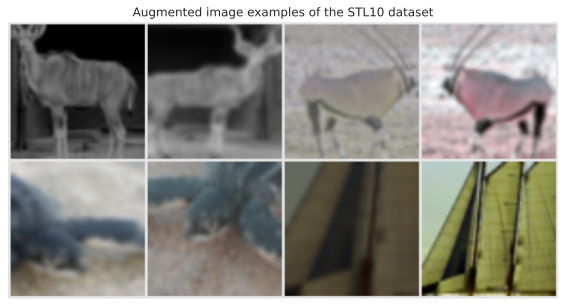

In [5]:
# Visualize some examples

pl.seed_everything(69)
NUM_IMAGES = 4
imgs = torch.stack([img for idx in range(NUM_IMAGES) for img in unlabeled_data[idx][0]], dim=0)
img_grid = torchvision.utils.make_grid(imgs, nrow=NUM_IMAGES, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(10,5))
plt.title('Augmented image examples of the STL10 dataset')
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

We can see that some objectively "important" features, like edges of animals and certain shapes, are preserved even though the blurring, color shifts and cropping.

# SimCLR

SimCLR (Simple Framework for Contrastive Learning of Visual Representations) is a framework for implementing contrastive learning of images. *Contrastive learning* is one method of self-supervised learning. We want to learn a data representation that can represent an image as a set outputs representing "useful" features of the data. We can then use these improved representations in downstream tasks.

To do this, we train a neural network to give us outputs that allows for correct clustering. We can do this by checking the cosine similarities of our representations of two similar inputs, and training our algorithm such that these representations are much more similar than those of unrelated data. If we perform random sets of transformations (cropping or flipping an image horizontally, etc) twice to an input, we're left with two similar inputs that we can use for training.

This representation learning can be done with a set of two functions. The first function, $f(\cdot)$, is a regular neural net. We then append to this $g(\cdot)$, which maps the output of $f$ to a latent space where we can calculate loss more easily.

Let's start to implement it.

# SimCLR implementation

We implement SimCLR with a basic resnet18 architecture.

In [6]:
# now that we have this pipeline, we can start training the model.
# first thing we need is some kind of loss function that will compare the two vectors and see how similar they are vs how similar they should be
# we'll use cosine similarity for this, packaged within InfoNCE loss
# InfoNCE: makes sure that the vector is only similar to one by comparing it to the pair vector AND the softmax of all the other vectors

class SimCLR(pl.LightningModule):

    def __init__(self, hidden_dim, lr, temperature, weight_decay, max_epochs=500):
        super().__init__()
        self.save_hyperparameters() # special function of lightning
        assert self.hparams.temperature > 0.0, 'The temperature must be a positive float!'

        # this is the first classifier (f(*))
        # remember that resnets are for image recognition, just prebuilt nns
        # hidden_dim is the size of the output of the vector representation of the image
        # I think 4*hidden_dim is just an arbitrary choice, I'll try to change it and see what happens
        self.convnet = torchvision.models.resnet18(num_classes=4*hidden_dim)  # Output of last linear layer

        # second linear classifier (g(*)) for comparing the vectors
        # these lines just add on a ReLU and final linear output to the vector
        # I don't really understand why they have to do that though
        self.convnet.fc = nn.Sequential(
            self.convnet.fc,  # Linear(ResNet output, 4*hidden_dim)
            nn.ReLU(inplace=True),
            nn.Linear(4*hidden_dim, hidden_dim)
        )

    # optimizers are things that update the weights of your nn, like a SGD optimizer or something like that
    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(),
                                lr=self.hparams.lr,
                                weight_decay=self.hparams.weight_decay)
        # helps to define the learning rate
        # cosine annealing scheduling just decresases the learning rate over time by a fancy factor
        lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer,
                                                            T_max=self.hparams.max_epochs,
                                                            eta_min=self.hparams.lr/50)
        return [optimizer], [lr_scheduler]

    # need: training loop, step, update weights, loss function

    def info_nce_loss(self, batch, mode='train'):
        imgs, _ = batch
        imgs = torch.cat(imgs, dim=0)

        # Encode all images
        feats = self.convnet(imgs)
        # Calculate cosine similarity
        cos_sim = F.cosine_similarity(feats[:,None,:], feats[None,:,:], dim=-1)
        # Mask out cosine similarity to itself
        self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
        cos_sim.masked_fill_(self_mask, -9e15)
        # Find positive example -> batch_size//2 away from the original example
        pos_mask = self_mask.roll(shifts=cos_sim.shape[0]//2, dims=0)
        # InfoNCE loss
        cos_sim = cos_sim / self.hparams.temperature
        nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
        nll = nll.mean()

        # Logging loss
        self.log(mode+'_loss', nll)
        # Get ranking position of positive example
        comb_sim = torch.cat([cos_sim[pos_mask][:,None],  # First position positive example
                              cos_sim.masked_fill(pos_mask, -9e15)],
                             dim=-1)
        sim_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)
        # Logging ranking metrics
        self.log(mode+'_acc_top1', (sim_argsort == 0).float().mean())
        self.log(mode+'_acc_top5', (sim_argsort < 5).float().mean())
        self.log(mode+'_acc_mean_pos', 1+sim_argsort.float().mean())

        return nll

    def training_step(self, batch, batch_idx):
        return self.info_nce_loss(batch, mode='train')

    def validation_step(self, batch, batch_idx):
        self.info_nce_loss(batch, mode='val')

We can train our SimCLR model on some data now, to check it's effects on some downstream task (to be defined later).

In [7]:
# this is how we train the simclr. the trained simclr will then output useful vector representations for the images

def train_simclr(batch_size, max_epochs=500, **kwargs):
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, 'SimCLR'),
                         accelerator="gpu" if str(device).startswith("cuda") else "cpu",
                         devices=1,
                         max_epochs=max_epochs,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode='max', monitor='val_acc_top5'),
                                    LearningRateMonitor('epoch')])
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, 'SimCLR.ckpt')


    if os.path.isfile(pretrained_filename):
        print(f'Found pretrained model at {pretrained_filename}, loading...')
        model = SimCLR.load_from_checkpoint(pretrained_filename) # Automatically loads the model with the saved hyperparameters


    else:
        train_loader = data.DataLoader(unlabeled_data, batch_size=batch_size, shuffle=True,
                                       drop_last=True, pin_memory=True, num_workers=NUM_WORKERS)
        val_loader = data.DataLoader(train_data_contrast, batch_size=batch_size, shuffle=False,
                                     drop_last=False, pin_memory=True, num_workers=NUM_WORKERS)
        pl.seed_everything(42) # To be reproducible
        model = SimCLR(max_epochs=max_epochs, **kwargs)
        trainer.fit(model, train_loader, val_loader)
        model = SimCLR.load_from_checkpoint(trainer.checkpoint_callback.best_model_path) # Load best checkpoint after training

    return model

In [ ]:
simclr_model = train_simclr(batch_size=256,
                            hidden_dim=128,
                            lr=5e-4,
                            temperature=0.07,
                            weight_decay=1e-4,
                            max_epochs=500)

To test the utility of this representation learning, we can define a downstream task to use our new image representations on. Here, we'll just use a simple logreg classifier.

In [9]:
# logistic regression
# you try to learn the parameters of the function that best fits the data

class LogisticRegression(pl.LightningModule):

    def __init__(self, feature_dim, num_classes, lr, weight_decay, max_epochs=100):
        super().__init__()
        self.save_hyperparameters()
        self.model = nn.Linear(feature_dim, num_classes)

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(),
                                lr=self.hparams.lr,
                                weight_decay=self.hparams.weight_decay)
        lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer,
                                                      milestones=[int(self.hparams.max_epochs*0.6),
                                                                  int(self.hparams.max_epochs*0.8)],
                                                      gamma=0.1)
        return [optimizer], [lr_scheduler]

    def _calculate_loss(self, batch, mode='train'):
        feats, labels = batch
        preds = self.model(feats)
        loss = F.cross_entropy(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()

        self.log(mode + '_loss', loss)
        self.log(mode + '_acc', acc)
        return loss

    def training_step(self, batch, batch_idx):
        return self._calculate_loss(batch, mode='train')

    def validation_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode='val')

    def test_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode='test')

In [ ]:
# image transforms pipeline

img_transforms = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize((0.5,), (0.5,))])

train_img_data = STL10(root=DATASET_PATH, split='train', download=True,
                       transform=img_transforms)
test_img_data = STL10(root=DATASET_PATH, split='test', download=True,
                      transform=img_transforms)

print("Number of training examples:", len(train_img_data))
print("Number of test examples:", len(test_img_data))



Now, let's use our trained representation model to encode the images as vectors of "useful" features. We can also remove the final layer $g$, as it simply served to map the final representations to a space where they could be compared.

In [11]:
# we are done training, so we remove g() and then pipe the output of f into our logreg

@torch.no_grad()
def prepare_data_features(model, dataset):
    # Prepare model
    network = deepcopy(model.convnet)
    network.fc = nn.Identity()  # Removing projection head g(.) as explained above
    network.eval()
    network.to(device)

    # Encode all images
    data_loader = data.DataLoader(dataset, batch_size=64, num_workers=NUM_WORKERS, shuffle=False, drop_last=False)
    feats, labels = [], []
    for batch_imgs, batch_labels in tqdm(data_loader):
        batch_imgs = batch_imgs.to(device)
        batch_feats = network(batch_imgs) # get features from nn
        feats.append(batch_feats.detach().cpu())
        labels.append(batch_labels) # attach labels


    feats = torch.cat(feats, dim=0)
    labels = torch.cat(labels, dim=0)

    # Sort images by labels
    labels, idxs = labels.sort()
    feats = feats[idxs]

    return data.TensorDataset(feats, labels)

## the logistic regression will attempt to classify the images into their correct labels
## it should be better now because we've learned the most important features with the first neural network
## so our logistic regression should be more accurate now that we have better feature representations

In [ ]:
train_feats_simclr = prepare_data_features(simclr_model, train_img_data)
test_feats_simclr = prepare_data_features(simclr_model, test_img_data)

We've converted the various transformed images into their new, learned representations. At the end, we are left with a dataset dict of features to labels, which we will use in our logistic regression classifier as inputs, rather than the original images.

In [13]:
# train the logreg to classify the images into actual labels using our new vector representation

def train_logreg(batch_size, train_feats_data, test_feats_data, model_suffix, max_epochs=100, **kwargs):
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, "LogisticRegression"),
                         accelerator="gpu" if str(device).startswith("cuda") else "cpu",
                         devices=1,
                         max_epochs=max_epochs,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode='max', monitor='val_acc'),
                                    LearningRateMonitor("epoch")],
                         enable_progress_bar=False,
                         check_val_every_n_epoch=10)
    trainer.logger._default_hp_metric = None

    # Data loaders
    train_loader = data.DataLoader(train_feats_data, batch_size=batch_size, shuffle=True,
                                   drop_last=False, pin_memory=True, num_workers=0)
    test_loader = data.DataLoader(test_feats_data, batch_size=batch_size, shuffle=False,
                                  drop_last=False, pin_memory=True, num_workers=0)

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, f"LogisticRegression_{model_suffix}.ckpt")
    if os.path.isfile(pretrained_filename):
        print(f"Found pretrained model at {pretrained_filename}, loading...")
        model = LogisticRegression.load_from_checkpoint(pretrained_filename)
    else:
        pl.seed_everything(42)  # To be reproducible
        model = LogisticRegression(**kwargs)
        trainer.fit(model, train_loader, test_loader)
        model = LogisticRegression.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

    # Test best model on train and validation set
    train_result = trainer.test(model, train_loader, verbose=False)
    test_result = trainer.test(model, test_loader, verbose=False)
    result = {"train": train_result[0]["test_acc"], "test": test_result[0]["test_acc"]}

    return model, result

In [14]:
# this just grabs the first x images per label
def get_smaller_dataset(original_dataset, num_imgs_per_label):
    new_dataset = data.TensorDataset(
        *[t.unflatten(0, (10, -1))[:,:num_imgs_per_label].flatten(0, 1) for t in original_dataset.tensors]
    )
    return new_dataset

In [ ]:
# testing variations based on how many examples for each label we get
# I guess we're training the logreg right now, so more examples lets it more effectively use the new representations? seems a bit obvious

results = {}
for num_imgs_per_label in [10, 20, 50, 100, 200, 500]:
    sub_train_set = get_smaller_dataset(train_feats_simclr, num_imgs_per_label)
    _, small_set_results = train_logreg(batch_size=64,
                                        train_feats_data=sub_train_set,
                                        test_feats_data=test_feats_simclr,
                                        model_suffix=num_imgs_per_label,
                                        feature_dim=train_feats_simclr.tensors[0].shape[1],
                                        num_classes=10,
                                        lr=1e-3,
                                        weight_decay=1e-3)
    results[num_imgs_per_label] = small_set_results # add to dict



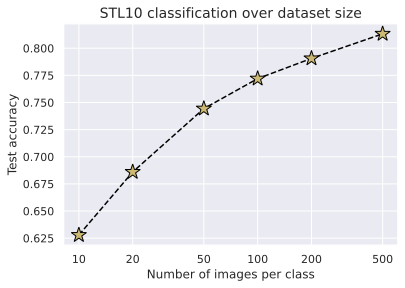

Test accuracy for  10 images per label: 62.79%
Test accuracy for  20 images per label: 68.60%
Test accuracy for  50 images per label: 74.44%
Test accuracy for 100 images per label: 77.20%
Test accuracy for 200 images per label: 79.06%
Test accuracy for 500 images per label: 81.33%


In [16]:
dataset_sizes = sorted([k for k in results])
test_scores = [results[k]["test"] for k in dataset_sizes]

fig = plt.figure(figsize=(6,4))
plt.plot(dataset_sizes, test_scores, '--', color="#000", marker="*", markeredgecolor="#000", markerfacecolor="y", markersize=16)
plt.xscale("log")
plt.xticks(dataset_sizes, labels=dataset_sizes)
plt.title("STL10 classification over dataset size", fontsize=14)
plt.xlabel("Number of images per class")
plt.ylabel("Test accuracy")
plt.minorticks_off()
plt.show()

for k, score in zip(dataset_sizes, test_scores):
    print(f'Test accuracy for {k:3d} images per label: {100*score:4.2f}%')



On the full dataset, we achieve an accuracy of 81.33%. Even with only $1/10$ of the data, we still lose less than 10% of accuracy. To see the objective benefit of self-supervised learning before training, we'll classify the same dataset using a regular resnet18 architecture with the original image dataset.

In [17]:
# now train regular resnet18 on the code

# train the logreg to classify the images into actual labels using our new vector representation

# define the model
# define the training updates and optimization functions
# call the model function

class ResNet(pl.LightningModule):

    def __init__(self, num_classes, lr, weight_decay, max_epochs=100):
        super().__init__()
        self.save_hyperparameters()
        self.model = torchvision.models.resnet18(num_classes=num_classes)

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(),
                                lr=self.hparams.lr,
                                weight_decay=self.hparams.weight_decay)
        lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer,
                                                      milestones=[int(self.hparams.max_epochs*0.7),
                                                                  int(self.hparams.max_epochs*0.9)],
                                                      gamma=0.1)
        return [optimizer], [lr_scheduler]

    def _calculate_loss(self, batch, mode='train'):
        imgs, labels = batch
        preds = self.model(imgs)
        loss = F.cross_entropy(preds, labels) # difference between predicted distribution and actual
        acc = (preds.argmax(dim=-1) == labels).float().mean()

        self.log(mode + '_loss', loss)
        self.log(mode + '_acc', acc)
        return loss

    def training_step(self, batch, batch_idx):
        return self._calculate_loss(batch, mode='train')

    def validation_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode='val')

    def test_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode='test')

In [ ]:
# need to change image transforms we do, because we aren't using the pretrainer now which worked better with the crop and color change

train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                       transforms.RandomResizedCrop(size=96, scale=(0.8, 1.0)),
                                       transforms.RandomGrayscale(p=0.2),
                                       transforms.GaussianBlur(kernel_size=9, sigma=(0.1, 0.5)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5,), (0.5,))
                                       ])

train_img_aug_data = STL10(root=DATASET_PATH, split='train', download=True,
                           transform=train_transforms)

In [19]:
def train_resnet(batch_size, max_epochs=100, **kwargs):

    # fancy lightning packager to make it easy
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, "ResNet"),
                         accelerator="gpu" if str(device).startswith("cuda") else "cpu",
                         devices=1,
                         max_epochs=max_epochs,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc"),
                                    LearningRateMonitor("epoch")],
                         check_val_every_n_epoch=2)
    trainer.logger._default_hp_metric = None

    # Data loaders using the new transforms (in train_img_aug_data)
    train_loader = data.DataLoader(train_img_aug_data, batch_size=batch_size, shuffle=True,
                                   drop_last=True, pin_memory=True, num_workers=NUM_WORKERS)
    test_loader = data.DataLoader(test_img_data, batch_size=batch_size, shuffle=False,
                                  drop_last=False, pin_memory=True, num_workers=NUM_WORKERS)

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, "ResNet.ckpt")
    if os.path.isfile(pretrained_filename):
        print("Found pretrained model at %s, loading..." % pretrained_filename)
        model = ResNet.load_from_checkpoint(pretrained_filename)
    else:
        pl.seed_everything(42) # To be reproducible
        model = ResNet(**kwargs)
        trainer.fit(model, train_loader, test_loader)
        model = ResNet.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

    # Test best model on validation set
    train_result = trainer.test(model, train_loader, verbose=False)
    val_result = trainer.test(model, test_loader, verbose=False)
    result = {"train": train_result[0]["test_acc"], "test": val_result[0]["test_acc"]}

    return model, result

In [21]:
resnet_model, resnet_result = train_resnet(batch_size=64,
                                           num_classes=10,
                                           lr=1e-3,
                                           weight_decay=2e-4,
                                           max_epochs=100)
print(f"Accuracy on training set: {100*resnet_result['train']:4.2f}%")
print(f"Accuracy on test set: {100*resnet_result['test']:4.2f}%")



INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Found pretrained model at ../saved_models/tutorial17/ResNet.ckpt, loading...


INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.3.4 to v2.2.1. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../saved_models/tutorial17/ResNet.ckpt`


Testing: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

Accuracy on training set: 99.62%
Accuracy on test set: 73.31%


As we can see, on the full dataset, we achieve only a 73.31% accuracy score (even worse than our SimCLR on 10% of the data). So, our pre-training definitely works in this case!